# Neural Network

# Library Imports

In [16]:
import matplotlib.pyplot as plt
import tensorflow as tf
import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder, OneHotEncoder
from sklearn.metrics import classification_report, roc_auc_score,accuracy_score, precision_score, recall_score, f1_score
import pandas as pd
import numpy as np
from aif360.metrics import ClassificationMetric
from aif360.datasets import BinaryLabelDataset


# Load and Pre-processing Data Function


In [47]:
def process_and_load_data(data = pd.DataFrame, target = str):
# Define features to normalize (Min-Max)
    normalize_features = ['Weight', 'Body mass index', 'Systolic', 'Diastolic', 'Age',
       'Glycohemoglobin', 'Cholesterol',
       'High-density lipoprotein (HDL)', 'Albumin',
       'Alanine aminotransferase (ALT)', 'Aspartate aminotransferase (AST)',
       'Alkaline phosphatase (ALP)', 'Gamma-glutamyl transferase (GGT)',
       'Glucose', 'Iron', 'Lactate dehydrogenase (LDH)', 'Phosphorus',
       'Bilirubin', 'Protein', 'Triglycerides', 'Uric acid', 'Creatinine',
       'White blood cells', 'Basophils', 'Red blood cells', 'Hemoglobin',
       'Red blood cell width', 'Platelet count', 'Mean volume of platelets',
       'Moderate-work']

    # Categorical Columns
    categorical_cols = ['Diabetes', 'Blood related diabetes', 'Vigorous-work']

    # Initialize Scaler and Encoder
    minmax_scaler = MinMaxScaler()
    encoder = OneHotEncoder(drop="first", sparse_output=False)

    # Binarize Binary Categorical Columns
    data['Gender'] = data['Gender'].map({'Male': 1, 'Female': 0})
    data['Coronary heart disease'] = data['Coronary heart disease'].map({'Yes': 1, 'No': 0})

    # One-Hot Encoding Before Splitting
    encoded_data = encoder.fit_transform(data[categorical_cols])

    # Convert to DataFrame
    encoded_df = pd.DataFrame(encoded_data, columns=encoder.get_feature_names_out(categorical_cols), index=data.index)

    # Drop original categorical columns and concatenate one-hot encoded columns
    data = data.drop(columns=categorical_cols).reset_index(drop=True)
    encoded_df = encoded_df.reset_index(drop=True)
    data = pd.concat([data, encoded_df], axis=1)

    # Split Data into Features and Labels
    X = data.drop(target, axis=1)
    y = data[target]

    # Split Data into Train, Validation, and Test Sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42)

    # Normalization
    X_train[normalize_features] = minmax_scaler.fit_transform(X_train[normalize_features])
    X_val[normalize_features] = minmax_scaler.transform(X_val[normalize_features])
    X_test[normalize_features] = minmax_scaler.transform(X_test[normalize_features])

    return X_train, X_val, X_test, y_train, y_val, y_test


 


# Model Accuracy & Fairness Assessment Functions

## Function to test the Model's Accuracy

In [27]:
def model_assessment(predictions, actuals):
    
    #Overall
    overall_accuracy = accuracy_score(actuals, predictions)
    overall_recall = recall_score(actuals, predictions)
    overall_precision = precision_score(actuals, predictions)



    results = pd.DataFrame({
        'Group': ['Overall'],
        'Accuracy': [overall_accuracy],
        'Recall': [overall_recall],
        'Precision': [overall_precision]
    })

    return results





In [28]:
def thresholds_assessment(raw_predictions, actuals, thresholds = list):
    accs =[]
    recalls = []
    precs = []
    for threshold in thresholds:
        new_preds = (raw_predictions >= threshold).astype(int)
        accs.append(accuracy_score(actuals, new_preds))
        recalls.append(recall_score(actuals, new_preds))
        precs.append(precision_score(actuals, new_preds))
    return {'Accuracy': accs, 'Recall': recalls, 'Precision': precs}

## Function to test the Model's Fairness between Males and Females

In [9]:
def fairness_metrics(input_df, predictions):

    binary_dataset = BinaryLabelDataset(df=input_df, 
                                    label_names=['Coronary heart disease'], 
                                    protected_attribute_names=['Gender'])

    # Create predictions dataset
    pred_df = input_df.drop('Coronary heart disease', axis = 1)
    pred_df['Coronary heart disease'] = predictions
    binary_predictions = BinaryLabelDataset(df=pred_df, 
                                            label_names=['Coronary heart disease'], 
                                            protected_attribute_names=['Gender'])

    # Compute metrics
    metric = ClassificationMetric(binary_dataset, binary_predictions, 
                                unprivileged_groups=[{'Gender': 0}], 
                                privileged_groups=[{'Gender': 1}]) 
    
    demographic_parity_difference = metric.statistical_parity_difference()
    equal_opportunity_difference = metric.equal_opportunity_difference()
    predictive_parity = metric.statistical_parity_difference()
    disparate_impact = metric.disparate_impact()


    #Output Metrics in a Pandas DataFrame
    fairness_table = pd.DataFrame({
        'Metric': ['Demographic Parity Difference', 'Equal Opportunity Difference',
                   'Predictive Parity', 'Disparate Impact'],
        'Value': [demographic_parity_difference, equal_opportunity_difference,
                  predictive_parity, disparate_impact]
    })

    return fairness_table


# Load Data Set

In [50]:
df = pd.read_parquet('data/nhanes_data_processed.parquet')
df.head()

,Weight,Body mass index,Systolic,Diastolic,Gender,Age,Diabetes,Glycohemoglobin,Cholesterol,High-density lipoprotein (HDL),...,Basophils,Red blood cells,Hemoglobin,Red blood cell width,Platelet count,Mean volume of platelets,Coronary heart disease,Blood related diabetes,Moderate-work,Vigorous-work
4,92.5,29.10,122.0,82.0,Male,597.0,No,5.5,7.21,1.08,...,5.397605e-79,5.13,14.5,13.1,209.0,10.4,No,No,17.0,Yes
6,78.0,29.39,130.0,78.0,Female,712.0,No,5.8,6.34,2.73,...,5.397605e-79,4.60,13.4,14.3,244.0,8.2,No,Yes,3.0,No
9,111.8,30.94,152.0,98.0,Male,518.0,No,5.5,3.62,1.31,...,5.397605e-79,5.00,15.4,13.7,167.0,9.4,No,Don't know,13.0,Don't know
13,75.5,27.33,142.0,56.0,Male,973.0,No,5.8,4.50,1.04,...,5.397605e-79,5.32,16.6,12.4,160.0,9.0,No,No,9.0,Yes
14,81.6,26.68,106.0,68.0,Female,459.0,No,4.6,5.15,1.49,...,5.397605e-79,4.14,13.3,11.9,255.0,7.7,No,No,13.0,Yes


## Simple Baseline Neural Network

In [5]:
# Simple baseline model for 30 inputs
simple_nn = Sequential()
simple_nn.add(Dense(units=32, activation='relu', input_shape=(41,)))  # Input layer
simple_nn.add(Dropout(0.3))  # Dropout to prevent overfitting
simple_nn.add(Dense(units=16, activation='relu'))  # Hidden layer
simple_nn.add(Dense(1, activation='sigmoid'))  # Output layer

# Compile the model
adam = keras.optimizers.Adam(learning_rate=0.001)
simple_nn.compile(loss='binary_crossentropy', optimizer=adam, metrics=["accuracy"])

# Summary of the model
simple_nn.summary()



Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 32)                1344      
                                                                 
 dropout (Dropout)           (None, 32)                0         
                                                                 
 dense_1 (Dense)             (None, 16)                528       
                                                                 
 dense_2 (Dense)             (None, 1)                 17        
                                                                 
Total params: 1889 (7.38 KB)
Trainable params: 1889 (7.38 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


# Create Train/Test/Validation Sets

In [51]:
X_train, X_test, X_val, y_train, y_test, y_val = process_and_load_data(df, 'Coronary heart disease')

In [52]:
X_train['Gender']

10319    1
39944    1
36843    1
41080    1
37500    1
        ..
15776    0
41454    1
32914    1
2254     1
42246    1
Name: Gender, Length: 27492, dtype: int64

# Train Simple Neural Network

In [53]:
simple_nn.fit(X_train, y_train, epochs = 100)

Epoch 1/100
860/860 [==============================] - 1s 942us/step - loss: 0.1363 - accuracy: 0.9584
Epoch 2/100
860/860 [==============================] - 1s 906us/step - loss: 0.1357 - accuracy: 0.9584
Epoch 3/100
860/860 [==============================] - 1s 941us/step - loss: 0.1363 - accuracy: 0.9584
Epoch 4/100
860/860 [==============================] - 1s 907us/step - loss: 0.1369 - accuracy: 0.9584
Epoch 5/100
860/860 [==============================] - 1s 917us/step - loss: 0.1356 - accuracy: 0.9584
Epoch 6/100
860/860 [==============================] - 1s 935us/step - loss: 0.1362 - accuracy: 0.9584
Epoch 7/100
860/860 [==============================] - 1s 923us/step - loss: 0.1359 - accuracy: 0.9584
Epoch 8/100
860/860 [==============================] - 1s 935us/step - loss: 0.1362 - accuracy: 0.9584
Epoch 9/100
860/860 [==============================] - 1s 910us/step - loss: 0.1360 - accuracy: 0.9584
Epoch 10/100
860/860 [==============================] - 1s 916us/step - l

# Accuracy Assessment

### Test Set

In [54]:
loss_and_metrics = simple_nn.evaluate(X_test, y_test)
print(loss_and_metrics)
print('Loss = ',loss_and_metrics[0])
print('Accuracy = ',loss_and_metrics[1])

287/287 [==============================] - 0s 703us/step - loss: 0.1341 - accuracy: 0.9615
[0.13414545357227325, 0.9614797234535217]
Loss =  0.13414545357227325
Accuracy =  0.9614797234535217


### Predictions Evaulation

In [55]:
raw_preds = simple_nn.predict(X_val)

287/287 [==============================] - 0s 661us/step


### Default Threshold of 0.5

In [56]:
preds = (raw_preds >= 0.5).astype(int)

In [57]:
model_assessment(preds, y_val)

c:\Users\Diego\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,Group,Accuracy,Recall,Precision
0,Overall,0.959515,0.0,0.0


# Threshold Assesment

In [58]:
thresholds = np.arange(0.01,1, 0.05)

In [59]:
metrics = thresholds_assessment(raw_preds, y_val, thresholds)

c:\Users\Diego\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Diego\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Diego\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Diego\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision 

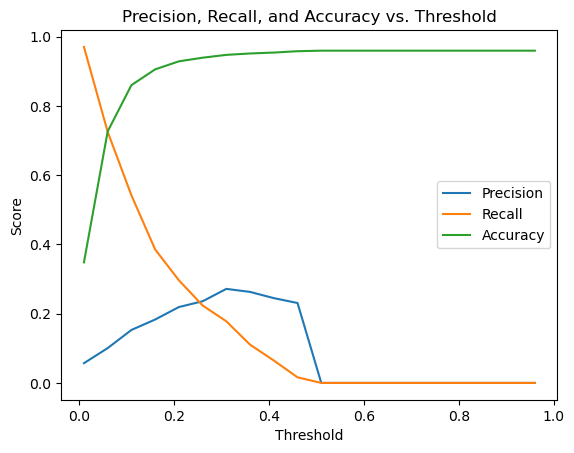

In [60]:
plt.plot(thresholds, metrics['Precision'], label='Precision')
plt.plot(thresholds, metrics['Recall'], label='Recall')
plt.plot(thresholds, metrics['Accuracy'], label='Accuracy')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('Precision, Recall, and Accuracy vs. Threshold')
plt.legend()
plt.show()

### F1-Score Evaluation

In [61]:
f1_scores = []
for t in thresholds:
    preds = (raw_preds >= t).astype(int)
    f1 = f1_score(y_val, preds)
    f1_scores.append(f1)

optimal_threshold = thresholds[f1_scores.index(max(f1_scores))]
print(f"Optimal threshold for F1-Score: {optimal_threshold}")

Optimal threshold for F1-Score: 0.21000000000000002


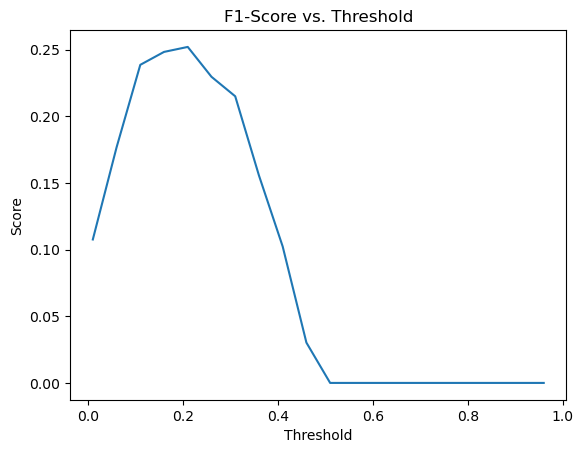

In [62]:
plt.plot(thresholds, f1_scores)
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('F1-Score vs. Threshold')
plt.show()

In [63]:
preds = (raw_preds >= 0.11).astype(int)

In [64]:
model_assessment(preds, y_val)

,Group,Accuracy,Recall,Precision
0,Overall,0.859996,0.541779,0.152968


# Fairness Assessment

In [22]:
import helpers

In [65]:
fairness_df = X_val.copy()
fairness_df['Coronary heart disease'] = y_val
helpers.fairness_metrics(fairness_df, preds)

,Metric,Value
0,Demographic Parity Difference,0.148728
1,Equal Opportunity Difference,0.332903
2,Predictive Parity,0.148728
3,Disparate Impact,3.094654
